In [1]:
#!/usr/bin/env python
import numpy as np
import sys
sys.path.append('../')
from tark import tark, rk, mylstsq

In [2]:
# Set parameters
n = 1000000
d = 25
num_steps = n
burn_in = 1000
num_threads = 10
mu = 0.999

In [3]:
# Define regression problem
f = lambda y: np.sin(np.pi * y) * np.exp(-2 * y) + np.cos(4 * np.pi * y)
pts = np.linspace(-1,1,num=n)
kk = np.arange(d)
A = pts[:,np.newaxis] ** kk[np.newaxis,:]
b = f(pts) + 0.2 * np.random.randn(n)
lamb = (1 - mu) / mu * np.linalg.norm(A, 'fro')**2
A_aug = np.vstack([A, np.sqrt(lamb) * np.identity(d)])
b_aug = np.concatenate([b, np.zeros(d)])
_, S, _ = np.linalg.svd(A, full_matrices=False)
print("Condition number of A is {}".format(max(S)/min(S)))

Condition number of A is 577067362.5239332


In [4]:
# Compute true solutions
x = mylstsq(A, b)
x_mu = mylstsq(A, b, lamb=lamb)

In [5]:
# Run RK methods
tark_history = tark(A, b, num_steps=num_steps, burn_in=burn_in)
rk_history = rk(A, b, num_steps=num_steps)

drk_history = rk(A, b, num_steps=num_steps, mu_reg=mu, dual=True)
tark_aug_history = tark(A_aug, b_aug, num_steps=num_steps, burn_in=burn_in)
rk_rr_history = rk(A, b, num_steps=num_steps, mu_reg=mu)
tark_rr_history = tark(A, b, num_steps=num_steps, mu_reg=mu, burn_in=burn_in)

100%|████████████████████████████████| 1000000/1000000 [00:07<00:00, 126322.45it/s]


In [6]:
# Set matplotlib parameters
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}"  # Ensure amsmath is included
})
plt.rcParams.update({'font.size': 20})
rkcolor = "#648FFF"
rkacolor = "#785EF0"
rkucolor = "#DC267F"
tarkcolor = "#FE6100"

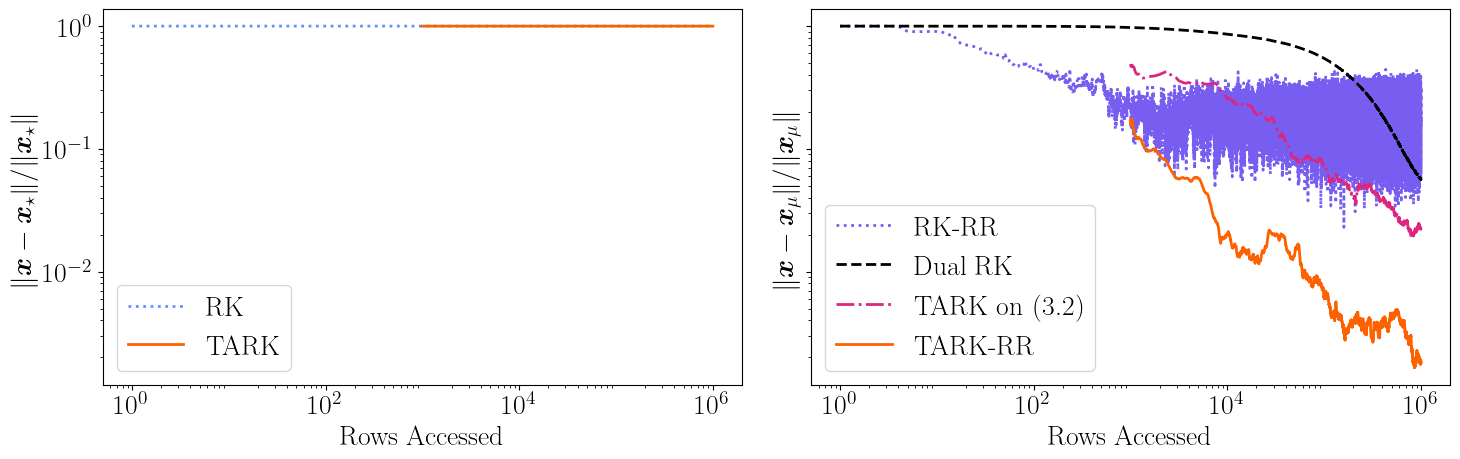

In [7]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))  # Adjust figsize as needed
x_ticks = [10**0, 10**2, 10**4, 10**6]

# First subplot
ax1.plot(range(1, num_steps+1), [np.linalg.norm(xx - x) / np.linalg.norm(x) for xx in rk_history], label="RK", color=rkcolor, linestyle="dotted", linewidth=2)
ax1.plot(range(burn_in+1, num_steps+1), [np.linalg.norm(xx - x) / np.linalg.norm(x) for xx in tark_history[burn_in:]], label="TARK", color=tarkcolor, linewidth=2)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xticks(x_ticks)
ax1.set_xlabel("Rows Accessed")
ax1.set_ylabel(r"$\|\boldsymbol{x}-\boldsymbol{x}_\star\| / \|\boldsymbol{x}_\star\|$")
ax1.legend()

# Second subplot
ax2.plot(range(1, num_steps+1), [np.linalg.norm(xx - x_mu) / np.linalg.norm(x_mu) for xx in rk_rr_history], label="RK-RR", color=rkacolor, linestyle="dotted", linewidth=2)
ax2.plot(range(1, num_steps+1), [np.linalg.norm(xx - x_mu) / np.linalg.norm(x_mu) for xx in drk_history], label="Dual RK", color="black", linestyle="dashed", linewidth=2)
ax2.plot(range(burn_in+1, num_steps+1), [np.linalg.norm(xx - x_mu) / np.linalg.norm(x_mu) for xx in tark_aug_history[burn_in:]], label="TARK on (3.2)", color=rkucolor, linestyle="dashdot", linewidth=2)
ax2.plot(range(burn_in+1, num_steps+1), [np.linalg.norm(xx - x_mu) / np.linalg.norm(x_mu) for xx in tark_rr_history[burn_in:]], label="TARK-RR", color=tarkcolor, linewidth=2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xticks(x_ticks)
ax2.set_xlabel("Rows Accessed")
ax2.set_ylabel(r"$\|\boldsymbol{x}-\boldsymbol{x}_\mu\| / \|\boldsymbol{x}_\mu\|$")
ax2.legend()

# Adjust layout and save the combined figure
plt.tight_layout()